2025-04-15 23:04:12.609 
  command:

    streamlit run /opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-04-15 23:04:12.612 No runtime found, using MemoryCacheStorageManager
2025-04-15 23:04:12.634 No runtime found, using MemoryCacheStorageManager


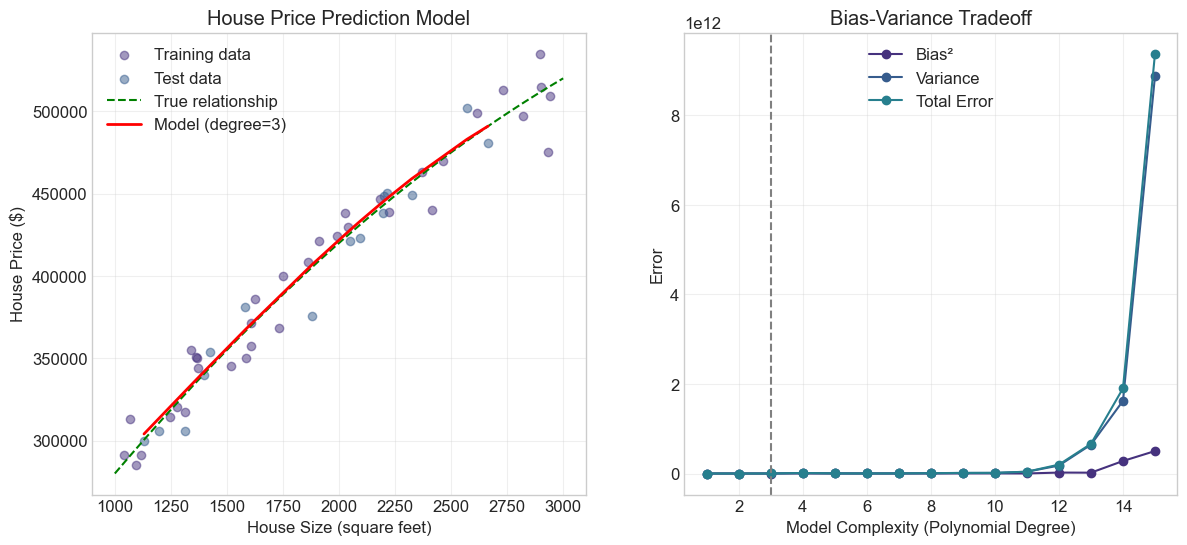

In [5]:
import streamlit as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Set page config
st.set_page_config(page_title="Bias-Variance Tradeoff Demo", page_icon="📈")

# Title and introduction
st.title("Bias-Variance Tradeoff Simulator")
st.write("""
This app demonstrates the bias-variance tradeoff using a house price prediction scenario.
Adjust the model complexity and see how it affects bias and variance.
""")

# Sidebar controls
st.sidebar.header("Model Settings")
complexity = st.sidebar.slider("Model Complexity (Polynomial Degree)", 1, 15, 3)
noise = st.sidebar.slider("Noise Level", 5000, 30000, 15000, 5000)
n_samples = st.sidebar.slider("Number of Samples", 20, 200, 50)
random_seed = st.sidebar.slider("Random Seed", 0, 100, 42)

# Function to generate data
def generate_data(n_samples, noise_level, seed):
    np.random.seed(seed)
    # House size between 1000 and 3000 sq ft
    X = np.random.uniform(1000, 3000, n_samples)
    
    # True housing price function
    # Base price + linear term + diminishing returns term
    base_price = 100000
    price_per_sqft = 200
    diminishing_return = -0.02
    
    true_price = base_price + price_per_sqft * X + diminishing_return * X**2
    
    # Add noise to simulate real-world variations
    noise = np.random.normal(0, noise_level, n_samples)
    observed_price = true_price + noise
    
    return X, observed_price, true_price

# Generate data
X, y, y_true = generate_data(n_samples, noise, random_seed)

# Split data
X_train, X_test, y_train, y_test, y_train_true, y_test_true = train_test_split(
    X, y, y_true, test_size=0.3, random_state=random_seed
)

# Fit model
model = make_pipeline(PolynomialFeatures(complexity), LinearRegression())
model.fit(X_train.reshape(-1, 1), y_train)
y_pred = model.predict(X_test.reshape(-1, 1))

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Calculate bias and variance through bootstrapping
def calculate_bias_variance(X, y, y_true, degree, n_bootstraps=30):
    n_samples = len(X)
    predictions = np.zeros((n_bootstraps, n_samples))
    
    for b in range(n_bootstraps):
        # Create bootstrap sample
        indices = np.random.choice(n_samples, n_samples, replace=True)
        X_boot = X[indices]
        y_boot = y[indices]
        
        # Fit model on bootstrap sample
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(X_boot.reshape(-1, 1), y_boot)
        
        # Predict on original data
        predictions[b, :] = model.predict(X.reshape(-1, 1)).flatten()
    
    # Average prediction across all bootstrap models
    expected_pred = np.mean(predictions, axis=0)
    
    # Calculate bias^2: (E[f̂(x)] - f(x))^2
    bias_squared = np.mean((expected_pred - y_true)**2)
    
    # Calculate variance: E[(f̂(x) - E[f̂(x)])^2]
    variance = np.mean(np.var(predictions, axis=0))
    
    return bias_squared, variance

# Calculate bias and variance for different model complexities
@st.cache_data
def calculate_tradeoff_curve(X, y, y_true, random_seed=42):
    np.random.seed(random_seed)
    degrees = range(1, 16)
    results = []
    
    for degree in degrees:
        bias_squared, variance = calculate_bias_variance(X, y, y_true, degree)
        results.append({
            'Degree': degree,
            'Bias²': bias_squared,
            'Variance': variance,
            'Total Error': bias_squared + variance
        })
    
    return pd.DataFrame(results)

# Calculate bias and variance for current model
bias_squared, variance = calculate_bias_variance(X_test, y_test, y_test_true, complexity)
total_error = bias_squared + variance

# Display metrics
col1, col2, col3 = st.columns(3)
col1.metric("Bias²", f"${bias_squared:.2f}")
col2.metric("Variance", f"${variance:.2f}")
col3.metric("Total Error", f"${total_error:.2f}")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Model fit
ax1.scatter(X_train, y_train, alpha=0.5, label='Training data')
ax1.scatter(X_test, y_test, alpha=0.5, label='Test data')

# Sort for smooth curve visualization
x_curve = np.linspace(1000, 3000, 1000)
y_curve = 100000 + 200 * x_curve + (-0.02) * x_curve**2
ax1.plot(x_curve, y_curve, '--', color='green', label='True relationship')

# Plot model prediction
X_sorted = np.sort(X_test)
y_pred_sorted = model.predict(X_sorted.reshape(-1, 1))
ax1.plot(X_sorted, y_pred_sorted, color='red', linewidth=2, label=f'Model (degree={complexity})')

ax1.set_title('House Price Prediction Model')
ax1.set_xlabel('House Size (square feet)')
ax1.set_ylabel('House Price ($)')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Bias-Variance Tradeoff
tradeoff_df = calculate_tradeoff_curve(X_test, y_test, y_test_true, random_seed)
ax2.plot(tradeoff_df['Degree'], tradeoff_df['Bias²'], 'o-', label='Bias²')
ax2.plot(tradeoff_df['Degree'], tradeoff_df['Variance'], 'o-', label='Variance')
ax2.plot(tradeoff_df['Degree'], tradeoff_df['Total Error'], 'o-', label='Total Error')
ax2.axvline(x=complexity, color='gray', linestyle='--')
ax2.set_title('Bias-Variance Tradeoff')
ax2.set_xlabel('Model Complexity (Polynomial Degree)')
ax2.set_ylabel('Error')
ax2.legend()
ax2.grid(alpha=0.3)

# Show the figure
st.pyplot(fig)

# Explanation based on model complexity
st.header("Explanation")

if complexity <= 2:
    st.info("""
        **High Bias, Low Variance (Underfitting)**
        
        This simple model can't capture the true non-linear relationship between house size and price.
        It has low variance because different training datasets would produce similar models.
        
        The model systematically undervalues large homes and overvalues small ones.
    """)
elif complexity >= 10:
    st.warning("""
        **Low Bias, High Variance (Overfitting)**
        
        This complex model closely fits the training data, including the noise.
        It has high variance because small changes in the training data cause large fluctuations in predictions.
        
        The model memorizes random market fluctuations rather than learning the true pattern.
    """)
else:
    st.success("""
        **Balanced Bias and Variance (Good Fit)**
        
        This model captures the true relationship while ignoring much of the random noise.
        It generalizes well to new, unseen properties.
        
        This is the sweet spot that balances model complexity.
    """)

# MSE Decomposition explanation
st.header("MSE Decomposition")
st.write("""
The Mean Squared Error can be decomposed into:

MSE = Bias² + Variance + Irreducible Error

Where:
- **Bias²**: How far off our average prediction is from the true value
- **Variance**: How much our prediction varies across different datasets
- **Irreducible Error**: The noise inherent in the problem
""")

# Add real estate context
st.header("Real Estate Context")
st.write("""
In our housing price scenario:
- **Underfitting models** (too simple) consistently misvalue properties
- **Overfitting models** (too complex) are unstable across different neighborhoods
- **Balanced models** provide reliable valuations that work well in new areas

Finding the right model complexity is crucial for a successful automated valuation model.
""")

# Deployment information
st.sidebar.markdown("---")
st.sidebar.header("About This App")
st.sidebar.write("""
This interactive simulation demonstrates the bias-variance tradeoff using polynomial regression.

To deploy this app:
1. Save this code as `bias_variance_app.py`
2. Install requirements: `pip install streamlit numpy pandas matplotlib scikit-learn`
3. Run: `streamlit run bias_variance_app.py`
""")